### Imports

In [1]:
import numpy as _np
import matplotlib.pyplot as _plt
import pymad8 as _m8
import beamTracking
import beamNeedle

Welcome to JupyROOT 6.29/01


### Date and prefix

In [2]:
date = "2024_02_12"
save_name_prefix = "plots/BeamNeedle/" + date + "_T20_plot"

# Track class definition

In [3]:
paramdict = {'x' : {'mean': 0, 'std': 10e-6}, #10e-6
             'xp': {'mean': 0, 'std': 10e-6}, #10e-6
             'y' : {'mean': 0, 'std': 10e-6}, #10e-6
             'yp': {'mean': 0, 'std': 10e-6}, #10e-6
             'z' : {'mean': 0, 'std': 30e-6}, #30e-6
             'DE': {'mean': 0, 'std': 3e-3},  #3e-3
            }

In [4]:
Track_Collection = beamTracking.setTrackCollection(100000, 14, paramdict, '../01_mad8/track_input_mad8', '../03_bdsimModel/track_input_bdsim')

Track = beamTracking.setSamplersAndTrack("../01_mad8/XFEL_T20/TWISS_CL_T20", "../01_mad8/XFEL_T20/RMAT_CL_T20")
Track.RunPymad8Tracking(Track_Collection)

Mad8.readTwissFile > nrec=878
Mad8.readRmatFile > nrec=878
Mad8.tracking > 100000 particles and 878 samplers


# SVD and BPM coefficients

In [5]:
ref_S = Track.twiss.getElementByNames('IP.LUXE.T20', 'S')
BPM_list_X = Track.getTheoryAndFit('X', ref_S, 'X', [1, 70, 130, 180, 220, 240, 260])[1]
MX, X_vect_IP, S_vect_X = Track.pymad8.buildBPMmatrix(ref_S, "X", BPM_list=BPM_list_X, BPM_list_type='pos', s_range=[-_np.inf, _np.inf], noise=10e-6, mean_sub=False)
C_X, C_Y= _np.split(Track.pymad8.SVD(MX, X_vect_IP), 2)

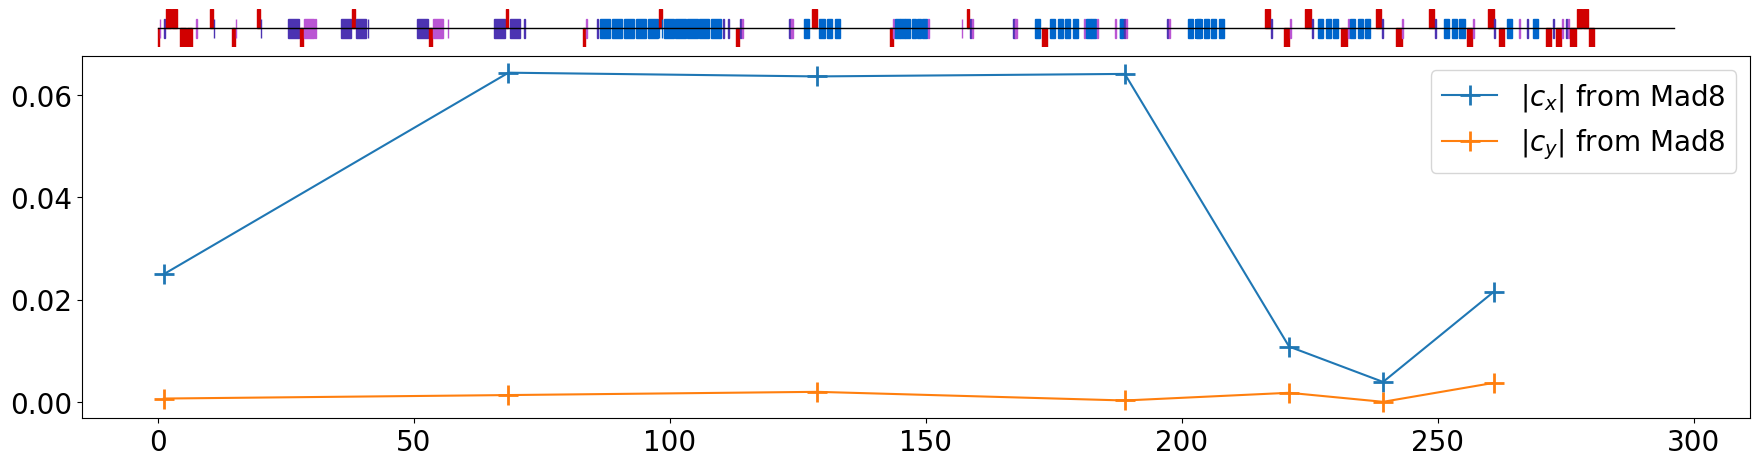

In [6]:
_plt.rcParams['font.size'] = 20
fig, ax = _plt.subplots(1,1,figsize=(18,5))
_plt.plot(S_vect_X, _np.abs(C_X), '+-', color='C0', markersize=15, markeredgewidth=2, label='$|c_x|$ from Mad8')
_plt.plot(S_vect_X, _np.abs(C_Y), '+-', color='C1', markersize=15, markeredgewidth=2, label='$|c_y|$ from Mad8')
_plt.legend()
_m8.Plot.AddMachineLatticeToFigure(_plt.gcf(), Track.twiss)

In [7]:
def PlotOptions():
    _plt.rcParams['font.size'] = 17
    fig, ax = _plt.subplots(1,1,figsize=(9,6))
    fig.tight_layout()

def ConvertTrackingPositionToNeedleMeasurement(TrackingVect, fitSlope=-1.75e13, fitError=1.8e6):
    OffsetError = fitError/_np.abs(fitSlope)
    GaussSpread = _np.random.normal(0, OffsetError, len(TrackingVect))
    return TrackingVect + GaussSpread

def ConvertTrackingPositionToNeedleMeasurementTEST(TrackingVect, fitSlope=-1.75e13, fitError=1.8e6):
    NeedleOffset = 6e-5
    b = 1.32e9
    val = fitSlope*NeedleOffset+b
    print("Measured photons : ", val)
    print("Error : ", fitError)
    print("Error pencentage : ", fitError/val*100)
    OffsetError = fitError/_np.abs(fitSlope)
    GaussSpread = _np.random.normal(0, OffsetError, len(TrackingVect))
    return GaussSpread

def CalcCoeffNeedle(BPM_Matrix, TrackingVect, fitSlope=-1.75e13, fitError=1.8e6):
    NeedleVect = ConvertTrackingPositionToNeedleMeasurement(TrackingVect, fitSlope, fitError)
    C_vect_needle = Track.pymad8.SVD(BPM_Matrix, NeedleVect)
    C_X_needle, C_Y_needle = _np.split(C_vect_needle, 2)
    return C_X_needle, C_Y_needle

def ScanCoeffDiffByFitError(BPM_Matrix, TrackingVect, fitSlope=-1.75e13, ErrorRange=[6, 9], nbpts=10):
    C_X, C_Y, _np.split(Track.pymad8.SVD(BPM_Matrix, TrackingVect), 2)
    ErrorArray = _np.logspace(ErrorRange[0], ErrorRange[1], nbpts)
    C_X_mean, C_Y_mean = (_np.array([]),_np.array([]))
    for error in ErrorArray:
        C_X_needle, C_Y_needle = CalcCoeffNeedle(BPM_Matrix, TrackingVect, fitSlope, error)
        C_X_mean = _np.append(C_X_mean, _np.mean(_np.abs(C_X-C_X_needle)))
        C_Y_mean = _np.append(C_Y_mean, _np.mean(_np.abs(C_Y-C_Y_needle)))
    return ErrorArray, C_X_mean, C_Y_mean

def CalcResolution(BPM_Matrix, TrackingVect):
    Meas_vect = _np.dot(BPM_Matrix, Track.pymad8.SVD(BPM_Matrix, TrackingVect))
    Res_hist = Meas_vect - TrackingVect
    return Res_hist

def CalcResolutionNeedle(BPM_Matrix, TrackingVect, fitSlope=-1.75e13, fitError=1.8e6):
    C_X_needle, C_Y_needle = CalcCoeffNeedle(BPM_Matrix, TrackingVect, fitSlope, fitError)
    Meas_vect = _np.dot(BPM_Matrix, _np.append(C_X_needle, C_Y_needle))
    Res_hist = Meas_vect - TrackingVect
    return Res_hist

def ScanResByFitError(BPM_Matrix, TrackingVect, fitSlope=-1.75e13, ErrorRange=[6, 9], nbpts=10):
    ErrorArray = _np.logspace(ErrorRange[0], ErrorRange[1], nbpts)
    ResArray = _np.array([])
    for error in ErrorArray:
        ResArray = _np.append(ResArray, _np.std(CalcResolutionNeedle(BPM_Matrix, TrackingVect, fitSlope, error)))
    return ErrorArray, ResArray

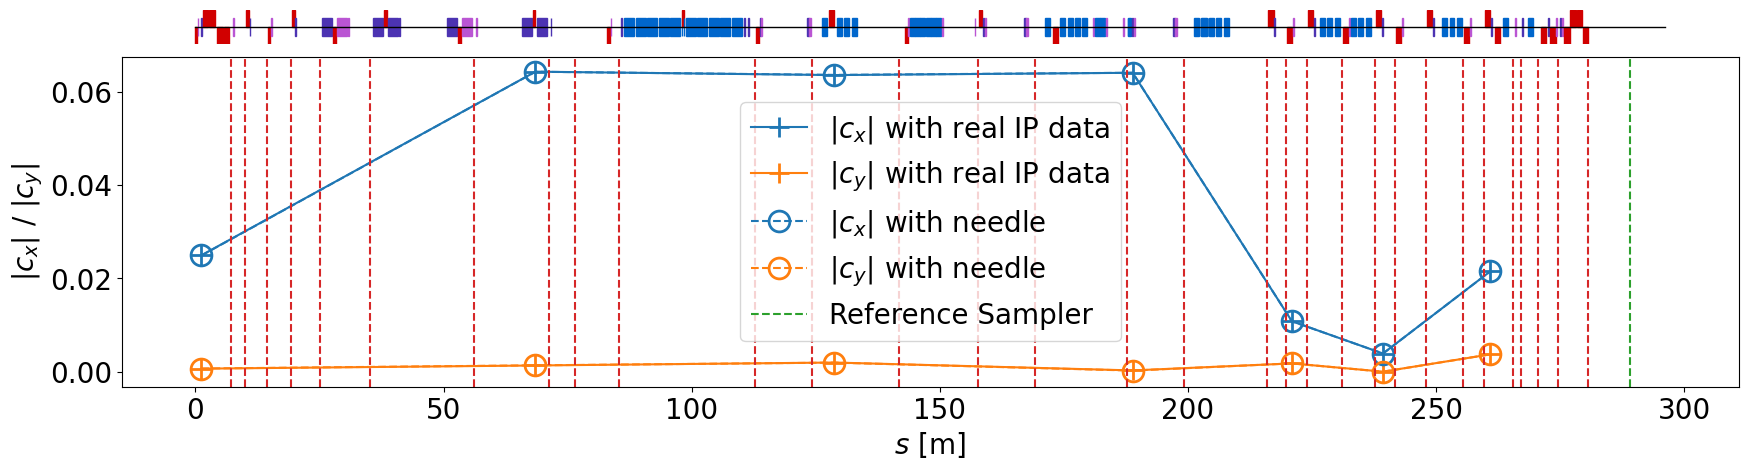

In [8]:
C_X_needle, C_Y_needle = CalcCoeffNeedle(MX, X_vect_IP, -1.75e13, 2.35e6)
_plt.rcParams['font.size'] = 20
fig, ax = _plt.subplots(1,1,figsize=(18,5))
_plt.plot(S_vect_X, _np.abs(C_X), '+-', color='C0', markersize=15, markeredgewidth=2, label='$|c_x|$ with real IP data')
_plt.plot(S_vect_X, _np.abs(C_Y), '+-', color='C1', markersize=15, markeredgewidth=2, label='$|c_y|$ with real IP data')
_plt.plot(S_vect_X, _np.abs(C_X_needle), 'o--', color='C0', markersize=15, markeredgewidth=2, markerfacecolor='None', label='$|c_x|$ with needle')
_plt.plot(S_vect_X, _np.abs(C_Y_needle), 'o--', color='C1', markersize=15, markeredgewidth=2, markerfacecolor='None', label='$|c_y|$ with needle')
_plt.axvline(ref_S, ls='--', color='C2', label='Reference Sampler')
for bpm in Track.twiss.getRowsByTypes("MONI")["S"].to_numpy():
    _plt.axvline(bpm, ls='--', color='C3')
_plt.ylabel('$|c_x|$ / $|c_y|$')
_plt.xlabel('$s$ [m]')
_plt.legend()
_m8.Plot.AddMachineLatticeToFigure(_plt.gcf(), Track.twiss)

_plt.savefig("{}_SVD_Correlation_in_X_with_needle".format(save_name_prefix), dpi=300, bbox_inches='tight')

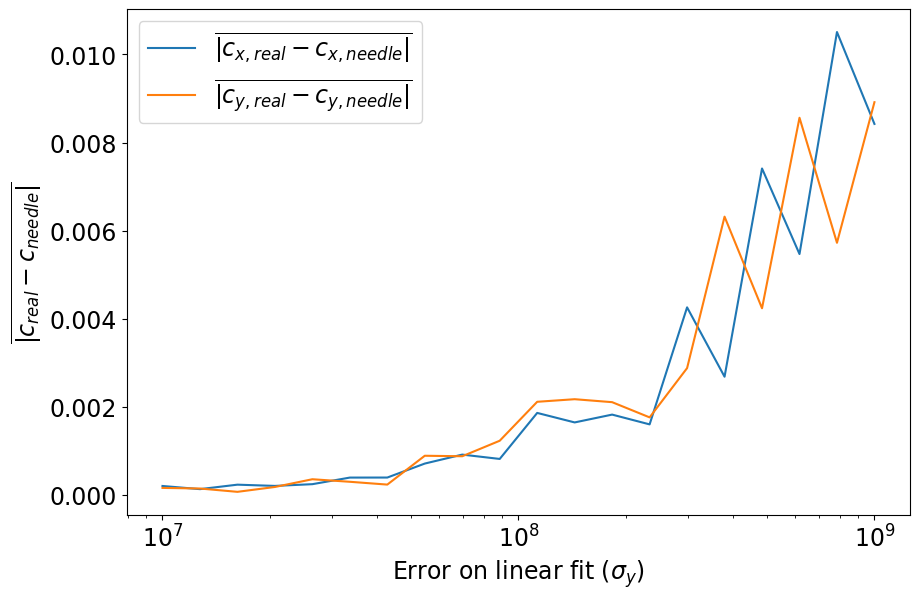

In [9]:
E,X,Y = ScanCoeffDiffByFitError(MX, X_vect_IP, ErrorRange=[7,9], nbpts=20)

PlotOptions()
_plt.plot(E, X, label=r'$\overline{|c_{x,real}-c_{x,needle}|}$')
_plt.plot(E, Y, label=r'$\overline{|c_{y,real}-c_{y,needle}|}$')
_plt.xscale("log")
#_plt.yscale("log")
_plt.ylabel(r'$\overline{|c_{real}-c_{needle}|}$')
_plt.xlabel(r'Error on linear fit ($\sigma_y$)')
_plt.legend()

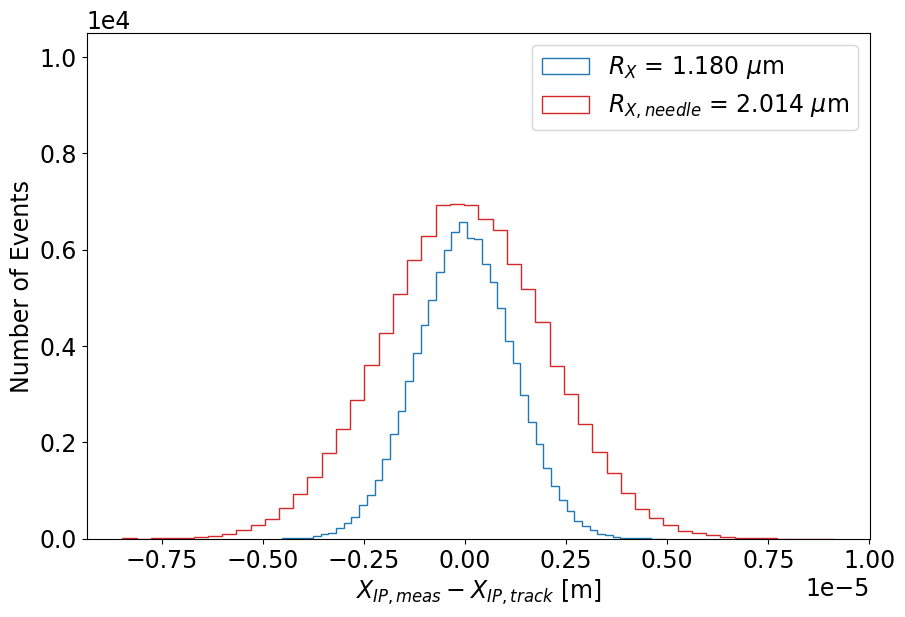

In [10]:
Res = CalcResolution(MX, X_vect_IP)
Res_needle = CalcResolutionNeedle(MX, X_vect_IP, -1.75e13, 2.35e9)

PlotOptions()
_plt.hist(Res, bins=50, histtype='step', color='C0',label='$R_X$ = {:1.3f} $\\mu$m'.format(_np.std(Res)*1e6))
_plt.hist(Res_needle, bins=50, histtype='step', color='C3',label='$R_{{{c}}}$ = {:1.3f} $\\mu$m'.format(_np.std(Res_needle)*1e6, c="X, needle"))
_plt.legend()
_plt.ylim(0,10500)
_plt.xlabel('$X_{IP,meas}-X_{IP,track}$ [m]')
_plt.ylabel('Number of Events')
_plt.ticklabel_format(axis='y', style='sci', scilimits=(4,4))

_plt.savefig("{}_Resolution_at_the_IP_with_needle_coeffs".format(save_name_prefix), dpi="figure", bbox_inches='tight', facecolor="#FF000000")

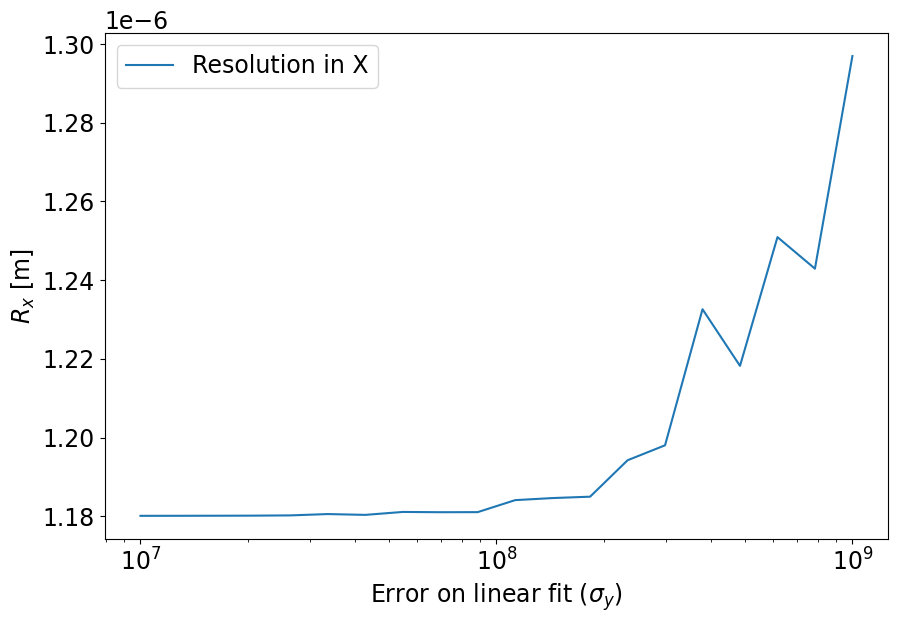

In [11]:
E, R = ScanResByFitError(MX, X_vect_IP, ErrorRange=[7,9], nbpts=20)

PlotOptions()
_plt.plot(E, R, label='Resolution in X')

_plt.xscale("log")
#_plt.yscale("log")
_plt.ylabel(r'$R_{x}$ [m]')
_plt.xlabel(r'Error on linear fit ($\sigma_y$)')
_plt.legend()

Measured photons :  270000000.0
Error :  2350000.0
Error pencentage :  0.8703703703703703


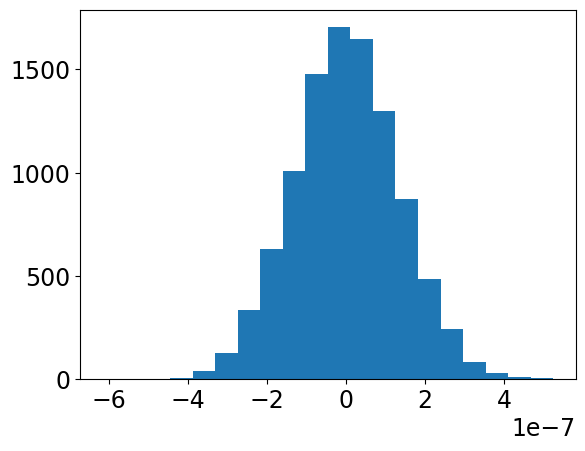

In [12]:
X = ConvertTrackingPositionToNeedleMeasurementTEST(_np.zeros(10000), fitSlope=-1.75e13, fitError=2.35e6)
h = _plt.hist(X, bins=20)

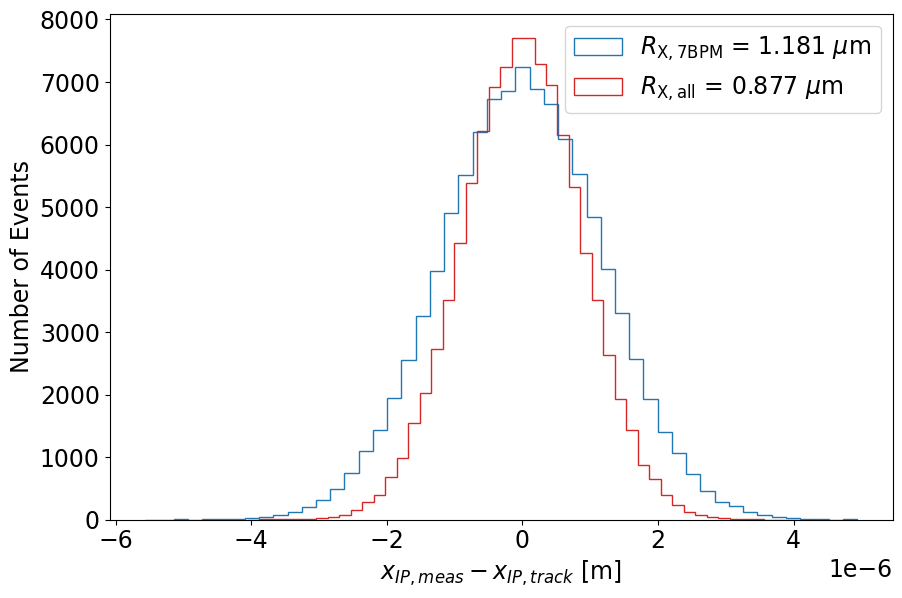

In [17]:
PlotOptions()
beamTracking.PlotResolution(Track, 'X', ref_S, {"X" : Track.getTheoryAndFit('X', ref_S, 'X', [1, 70, 130, 180, 220, 240, 260])[1]}, noise=10e-6, bdsimCompare=False)
beamTracking.PlotResolution(Track, 'X', ref_S, {"X" : Track.twiss.getRowsByTypes("MONI")["S"].to_numpy()}, noise=10e-6, bdsimCompare=False, color='C3')
_plt.legend([r'$R_{\rm X, 7 BPM}$ = 1.181 $\mu$m',r'$R_{\rm X, all}$ = 0.877 $\mu$m'], loc=1)